# 0. Import packages

In [128]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st 
from scipy import signal
from scipy.interpolate import griddata
import scipy
from rasterio.plot import show
from rasterio.transform import from_origin
import rasterio
import shapefile as shp
import glob
from pyproj import Transformer

%matplotlib widget

# 1. Load GPS points and boreholes

### 1.1 GPS points

In [74]:
gps_velocities = pd.read_csv('../GPS_velocities/24-25_velocities-good.csv')

GPS_points = []
for i in gps_velocities.iloc():
    GPS_points.append([i['x'], i['y']])

### 1.2 Boreholes

In [122]:
sf1 = shp.Reader("../Borehole_Locations/AH_core_locations_reproj.shp")

bor_shapes = sf1.shapes()
bor_records = sf1.records()

list_of_boreholes = ['ALHIC1902', 'ALHIC1903', 'ALHIC1901', 'ALHIC2201', 'ALHIC2301']

# 2. Load the imagery

<AxesSubplot:title={'center':'LIMA Imagery'}>

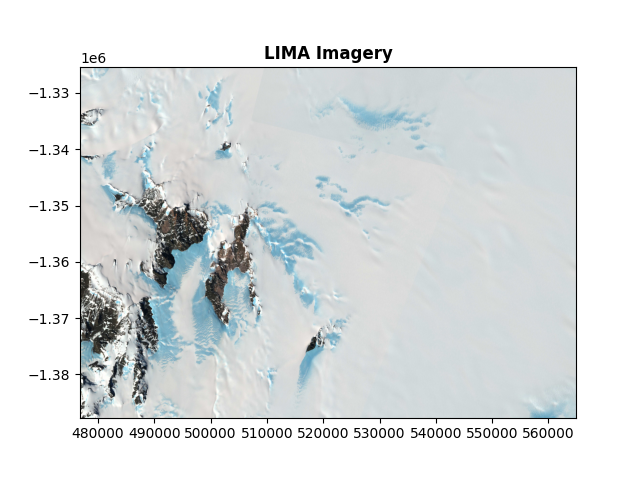

In [75]:
with rasterio.open('../imagery/LIMA_virtual_Mosaic_15m.tif') as src1:
    image_data = src1.read()

fig, ax = plt.subplots()

show(image_data, ax=ax, transform=src1.transform, title="LIMA Imagery")

# 3. Interpolate the velocity field

### 3.1 Create the grid to interpolate on

In [97]:
left, right, bottom, top = gps_velocities['x'].min(), gps_velocities['x'].max(), gps_velocities['y'].min(), gps_velocities['y'].max()
num_points = 50

# Create a regular grid to interpolate onto
grid_x, grid_y = np.meshgrid(
    np.linspace(left, right, num_points),
    np.linspace(bottom, top, num_points)
)

dx = (right - left) / num_points
dy = (top - bottom) / num_points

### 3.2 Do the interpolation

In [98]:
# Interpolate velocity components on the grid
u_grid = griddata(GPS_points, gps_velocities['u'].values, (grid_x, grid_y), method='cubic')
v_grid = griddata(GPS_points, gps_velocities['v'].values, (grid_x, grid_y), method='cubic')

### 3.3 Plot in a quiver plot

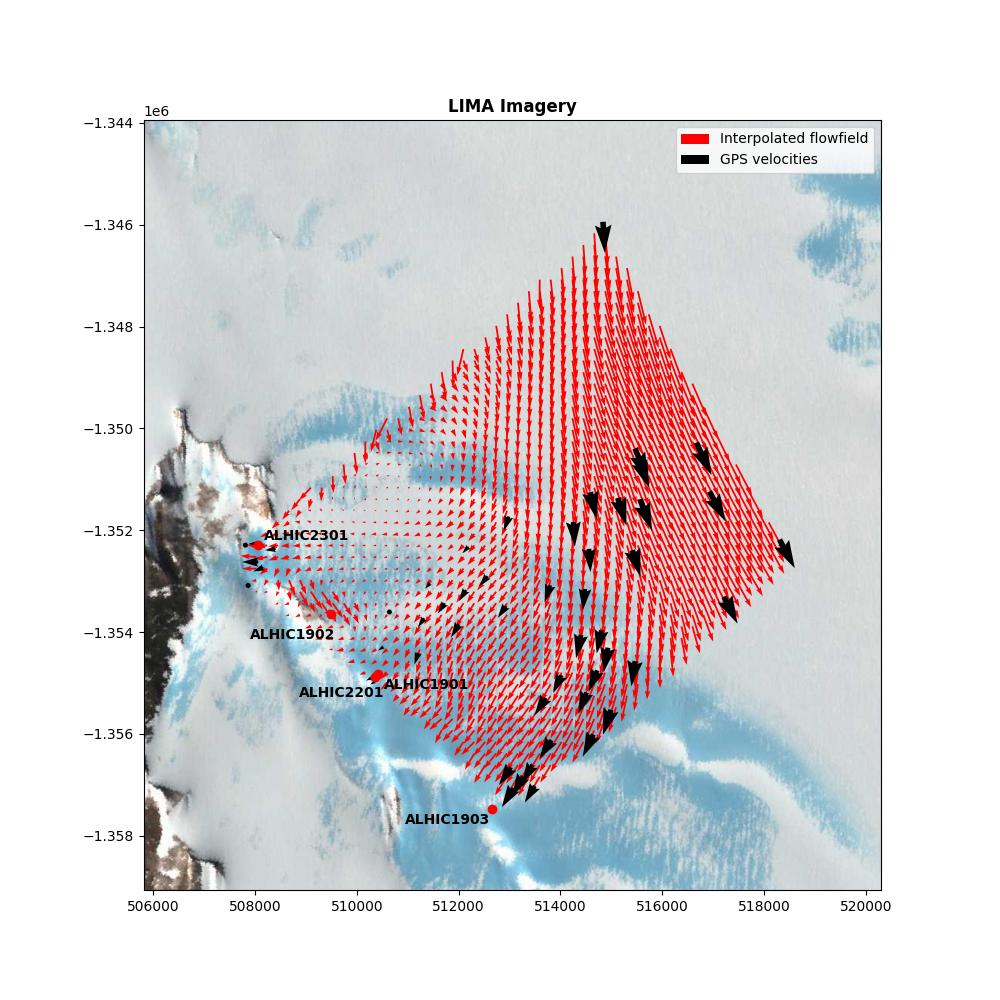

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.quiver(grid_x, grid_y, u_grid, v_grid, color='r', scale=10, label='Interpolated flowfield')
ax.quiver(gps_velocities['x'],gps_velocities['y'], 
          gps_velocities['u'], gps_velocities['v'], 
          scale = 10, label='GPS velocities')


## Borehole locations
for shape, record in zip(bor_shapes,bor_records):
    points = shape.points
    x, y = zip(*points)

    if record[0] in list_of_boreholes:
        ax.plot(x, y, 'o',color='red', markersize=6)


        if record[0] == 'ALHIC2201':
            ax.annotate(str(record[0]), (x[0] - 1500, y[0] - 400),weight="bold", fontsize=10)

        elif record[0] == 'ALHIC1902':
            ax.annotate(str(record[0]), (x[0] - 1600, y[0] - 500),weight="bold", fontsize=10)

        elif record[0] == 'ALHIC1903':
            ax.annotate(str(record[0]), (x[0] - 1700, y[0] - 300),weight="bold", fontsize=10)

        elif record[0] == 'ALHIC1901':
            ax.annotate(str(record[0]), (x[0] + 100, y[0] - 300),weight="bold", fontsize=10)

        else:
            ax.annotate(str(record[0]), (x[0] + 100, y[0] + 100),weight="bold", fontsize=10)

    else:
        continue


show(image_data, ax=ax, transform=src1.transform, title="LIMA Imagery")

buffer = 2e3
ax.set_xlim(left-buffer, right+buffer)
ax.set_ylim(bottom-buffer, top+buffer)
ax.legend()

### 3.4 Save the components of the flow field
#### Comment out if wanting to redo the saving of the flowfield

In [ ]:
# u_grid = np.reshape(u_grid, (1, u_grid.shape[0], u_grid.shape[1]))
# v_grid = np.reshape(v_grid, (1, v_grid.shape[0], v_grid.shape[1]))

# transform = from_origin(left, bottom, dx, -dy)

# u_output_path = 'u_velocity_interp.tif'

# # Metadata for the GeoTIFF (adjust as needed)
# metadata = {
#     'driver': 'GTiff',
#     'height': u_grid.shape[1],
#     'width': u_grid.shape[2],
#     'count': u_grid.shape[0],
#     'dtype': rasterio.float64,  # Or another appropriate data type
#     'crs': 'EPSG:3031',  # Coordinate reference system
#     'transform': transform,  # Adjust transform as needed
# }

# # Write the data to a GeoTIFF file
# with rasterio.open(u_output_path, 'w', **metadata) as dest:
#     dest.write(u_grid)

# v_output_path = 'v_velocity_interp.tif'

# # Metadata for the GeoTIFF (adjust as needed)
# metadata = {
#     'driver': 'GTiff',
#     'height': v_grid.shape[1],
#     'width': v_grid.shape[2],
#     'count': v_grid.shape[0],
#     'dtype': rasterio.float64,  # Or another appropriate data type
#     'crs': 'EPSG:3031',  # Coordinate reference system
#     'transform': transform,  # Adjust transform as needed
# }

# # Write the data to a GeoTIFF file
# with rasterio.open(v_output_path, 'w', **metadata) as dest:
#     dest.write(v_grid)

# 4. Load the identified "flowlines"

### 4.1 Manual flowline

In [133]:
sf2 = shp.Reader("../flowlines/manual_flowlines/borehole_flowlines_manual.shp")

man_shapes = sf2.shapes()
man_records = sf2.records()

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031")



### 4.2 Automatic flowlines (surface topography)

In [124]:
sf3 = shp.Reader("../flowlines/automatic_flowlines/shapefiles/Borehole_flowlines_merged.shp")
aut_shapes = sf3.shapes()
aut_records = sf3.records()

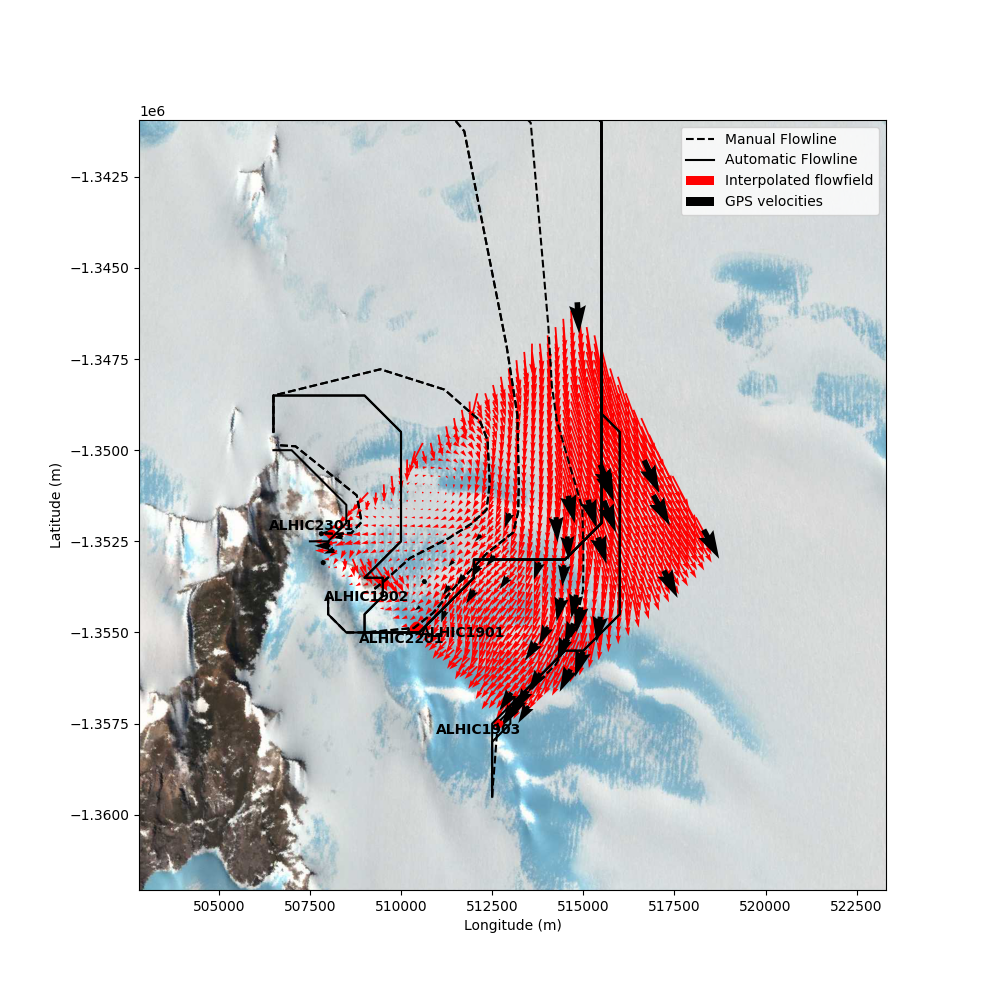

In [192]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.quiver(grid_x, grid_y, u_grid, v_grid, color='r', scale=10, label='Interpolated flowfield')
ax.quiver(gps_velocities['x'],gps_velocities['y'], 
          gps_velocities['u'], gps_velocities['v'], 
          scale = 10, label='GPS velocities')


## Borehole locations
for shape, record in zip(bor_shapes,bor_records):
    points = shape.points
    x, y = zip(*points)


    if record[0] in list_of_boreholes:
        ax.plot(x, y, 'o',color='red', markersize=6)


        if record[0] == 'ALHIC2201':
            ax.annotate(str(record[0]), (x[0] - 1500, y[0] - 400),weight="bold", fontsize=10)

        elif record[0] == 'ALHIC1902':
            ax.annotate(str(record[0]), (x[0] - 1600, y[0] - 500),weight="bold", fontsize=10)

        elif record[0] == 'ALHIC1903':
            ax.annotate(str(record[0]), (x[0] - 1700, y[0] - 300),weight="bold", fontsize=10)

        elif record[0] == 'ALHIC1901':
            ax.annotate(str(record[0]), (x[0] + 100, y[0] - 300),weight="bold", fontsize=10)

        else:
            ax.annotate(str(record[0]), (x[0] - 1700, y[0] + 100),weight="bold", fontsize=10)

    else:
        continue

## Flowlines
# manual
for n, (shape, record) in enumerate(zip(man_shapes,man_records)):
    points = shape.points
    x, y = zip(*points)
    flow_points = np.array((x,y)).T
    flow_points = np.array([transformer.transform(i[1], i[0]) for i in flow_points])
    x, y = flow_points[:,0], flow_points[:,1]
    if n==0:
        ax.plot(x, y,color='black', ls='--', label='Manual Flowline')
    else:
        ax.plot(x, y,color='black', ls='--')
# automatic
for n, (shape, record) in enumerate(zip(aut_shapes,aut_records)):
    points = shape.points
    x, y = zip(*points)
    if n == 0:
        ax.plot(x, y,'-k', label='Automatic Flowline')
    else:
        ax.plot(x, y,'-k')

### LIMA image
show(image_data, ax=ax, transform=src1.transform)

buffer = 5e3
ax.set_xlim(left-buffer, right+buffer)
ax.set_ylim(bottom-buffer, top+buffer)
ax.legend()

ax.set_ylabel('Latitude (m)')
ax.set_xlabel('Longitude (m)')
plt.savefig('Manual_flowlines.png', dpi=300, bbox_inches='tight')